# A Transfer Learning and Optimized CNN Based Intrusion Detection System using UNSW-NB15
This is the code for the paper entitled "**A Transfer Learning and Optimized CNN Based Intrusion Detection System for Internet of Vehicles**" accepted in IEEE International Conference on Communications (IEEE ICC).  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 1: Data pre-processing**  
Procedures:  
&nbsp; 1): Read the dataset  
&nbsp; 2): Transform the tabular data into images  
&nbsp; 3): Display the transformed images  
&nbsp; 4): Split the training and test set  

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

## Read the Car-Hacking/CAN-Intrusion dataset
The complete Car-Hacking dataset is publicly available at: https://ocslab.hksecurity.net/Datasets/CAN-intrusion-dataset  
In this repository, due to the file size limit of GitHub, we use the 5% subset.

In [2]:
#Read dataset
df=pd.read_csv('data/UNSW-NB15.csv')

In [3]:
df

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390.0,149.171.126.6,53.0,udp,CON,0.001055,132,164,31,...,0.0,3,7,1,3,1,1,1,Normal,0
1,59.166.0.0,33661.0,149.171.126.9,1024.0,udp,CON,0.036133,528,304,31,...,0.0,2,4,2,3,1,1,2,Normal,0
2,59.166.0.6,1464.0,149.171.126.7,53.0,udp,CON,0.001119,146,178,31,...,0.0,12,8,1,2,2,1,1,Normal,0
3,59.166.0.5,3593.0,149.171.126.5,53.0,udp,CON,0.001209,132,164,31,...,0.0,6,9,1,1,1,1,1,Normal,0
4,59.166.0.3,49664.0,149.171.126.0,53.0,udp,CON,0.001169,146,178,31,...,0.0,7,9,1,1,1,1,1,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,59.166.0.5,33094.0,149.171.126.7,43433.0,tcp,FIN,0.087306,320,1828,31,...,-1.0,1,2,3,3,1,1,3,Normal,0
2539735,59.166.0.7,20848.0,149.171.126.4,21.0,tcp,CON,0.365058,456,346,31,...,2.0,2,2,2,2,2,2,2,Normal,0
2539736,59.166.0.3,21511.0,149.171.126.9,21.0,tcp,CON,6.335154,1802,2088,31,...,2.0,2,2,4,2,2,2,2,Normal,0
2539737,59.166.0.9,35433.0,149.171.126.0,80.0,tcp,CON,2.200934,3498,166054,31,...,-1.0,1,1,2,4,2,2,2,Normal,0


In [4]:
df['attack_cat'].value_counts()

Normal            2218456
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             2329
Shellcode            1511
Worms                 174
Name: attack_cat, dtype: int64

In [5]:
# # Read the downloaded training set
# df_training = pd.read_csv('data/achieve/UNSW_NB15_training-set.csv', index_col='id')
# # Get feature set
# features = df_training.columns.to_list()
# # Adjustments
# # Rename some feature names to match the complete dataset
# rename_dict = {
#     'smean': 'smeansz',
#     'dmean': 'dmeansz',
#     'response_body_len': 'res_bdy_len',
#     'sinpkt': 'sintpkt',
#     'dinpkt': 'dintpkt'
# }
# features = list(map(lambda x: rename_dict[x] if x in rename_dict else x, features))
# # Remove feature 'rate' since it is not in the dataset
# features.remove('rate')
# # Remove feature 'label' to match the original code of MTH-IDS_IoTJ
# features.remove('label')
# # Release Memory
# del df_training

# For convenience
features = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth',
 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login',
 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']

print(features)

['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sintpkt', 'dintpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat']


In [6]:
# Only keep the influencing features
df = df[features]

### Data Sampling

In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
for col_name in df.dtypes[df.dtypes == 'object'].index.drop(['attack_cat']):
      df[col_name] = labelencoder.fit_transform(df[col_name])
df.insert(loc=len(df.columns), column='tmp_label', value=labelencoder.fit_transform(df['attack_cat']))

In [8]:
df['tmp_label'].value_counts()

6    2218456
5     215481
3      44525
4      24246
2      16353
7      13987
0       2677
1       2329
8       1511
9        174
Name: tmp_label, dtype: int64

In [9]:
# retain the minority class instances and sample the majority class instances
split_threshold = 10000
label_col = 'tmp_label'
df_minor = pd.DataFrame(columns=df.columns.to_list())
for cat_num, record_num in df[label_col].value_counts().to_dict().items():
    if record_num < split_threshold: df_minor=df_minor.append(df[df[label_col]==cat_num])
# df_minor = df[(df['tmp_label']==0)|(df['tmp_label']==1)|(df['tmp_label']==9)|(df['tmp_label']==2)|(df['tmp_label']==10)]
df_major = df.drop(df_minor.index)

In [10]:
X = df_major.drop(['attack_cat', 'tmp_label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [11]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [12]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [13]:
df_major['klabel'].value_counts()

435    22144
309    14799
578    10521
751    10168
252     9483
       ...  
257       92
74        45
302       14
0          3
233        2
Name: klabel, Length: 998, dtype: int64

In [14]:
len(df.columns.to_list())

43

In [15]:
cols = list(df_major)
cols.insert(len(cols)-2, cols.pop(cols.index('tmp_label')))
df_major = df_major.loc[:, cols]

In [16]:
df_major

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,tmp_label,klabel
0,0.001055,119,2,2,2,2,132,164,31,29,...,1,0.0,0.0,0.0,3,7,0,Normal,6,989
1,0.036133,119,0,2,4,4,528,304,31,29,...,2,0.0,0.0,0.0,3,4,0,Normal,6,19
2,0.001119,119,2,2,2,2,146,178,31,29,...,1,0.0,0.0,0.0,2,8,0,Normal,6,608
3,0.001209,119,2,2,2,2,132,164,31,29,...,1,0.0,0.0,0.0,1,9,0,Normal,6,891
4,0.001169,119,2,2,2,2,146,178,31,29,...,1,0.0,0.0,0.0,1,9,0,Normal,6,988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539734,0.087306,113,4,5,6,8,320,1828,31,29,...,3,-1.0,-1.0,-1.0,3,2,0,Normal,6,738
2539735,0.365058,113,3,2,8,6,456,346,31,29,...,2,2.0,2.0,-1.0,2,2,0,Normal,6,369
2539736,6.335154,113,3,2,32,30,1802,2088,31,29,...,2,2.0,2.0,-1.0,2,2,0,Normal,6,333
2539737,2.200934,113,5,2,58,116,3498,166054,31,29,...,2,-1.0,-1.0,2.0,4,1,0,Normal,6,673


In [17]:
def typicalSampling(group):
    name = group.name
    frac = 0.25
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [18]:
result['attack_cat'].value_counts()

Normal            554463
Generic            53883
Exploits           11143
Fuzzers             6083
DoS                 4199
Reconnaissance      3514
Name: attack_cat, dtype: int64

In [19]:
result

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,sttl,dttl,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,tmp_label,klabel
344364,0.138846,113,0,5,122,126,7806,14704,31,29,...,1,0.0,0.0,0.0,4,11,0,Normal,6,0
1335867,0.001031,119,2,2,2,2,130,162,31,29,...,1,-1.0,-1.0,-1.0,3,2,0,Normal,6,1
2049279,0.001032,119,2,2,2,2,130,162,31,29,...,5,-1.0,-1.0,-1.0,1,1,0,Normal,6,1
1262951,0.001032,119,2,2,2,2,130,162,31,29,...,2,-1.0,-1.0,-1.0,4,5,0,Normal,6,1
254651,0.001032,119,2,2,2,2,130,162,31,29,...,1,0.0,0.0,0.0,6,2,0,Normal,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597492,0.018873,113,0,5,40,42,2542,23432,31,29,...,1,0.0,0.0,0.0,5,6,0,Normal,6,999
1822269,0.099783,113,11,5,100,100,14512,17134,31,29,...,2,-1.0,-1.0,-1.0,1,1,0,Normal,6,999
642928,0.100028,113,0,5,60,62,3614,43086,31,29,...,1,0.0,0.0,0.0,5,6,0,Normal,6,999
2045587,1.005881,113,5,5,12,18,1580,10168,31,29,...,1,-1.0,-1.0,1.0,1,2,0,Normal,6,999


In [20]:
result = result.drop(['tmp_label', 'klabel'],axis=1)
df = result.append(df_minor.drop(['tmp_label'], axis=1))

In [21]:
df.to_csv('./data/UNSW-NB15_sample_km.csv',index=0)

In [22]:
# The labels of the dataset. "R" indicates normal patterns, and there are four types of attack (DoS, fuzzy. gear spoofing, and RPM spoofing zttacks)
df['attack_cat'].value_counts()

Normal            554463
Generic            53883
Exploits           11143
Fuzzers             6083
DoS                 4199
Reconnaissance      3514
Analysis            2677
Backdoor            2329
Shellcode           1511
Worms                174
Name: attack_cat, dtype: int64

### Feature Engineering

In [23]:
# df=pd.read_csv('./data/UNSW-NB15_sample_km.csv')

In [24]:
X = df.drop(['attack_cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [26]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [27]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [28]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [29]:
fs.append('attack_cat')
df = df[fs]
df

,sbytes,sload,sttl,smeansz,ct_state_ttl,dttl,dbytes,dmeansz,dur,dload,...,ct_srv_dst,spkts,ct_srv_src,ct_src_ltm,service,djit,sjit,swin,sloss,attack_cat
344364,7806,446134.593800,31,64,0,29,14704,117,0.138846,8.405284e+05,...,11,122,9,4,0,101.243717,102.997624,255,30,Normal
1335867,130,504364.656300,31,65,0,29,162,81,0.001031,6.285160e+05,...,2,2,4,3,2,0.000000,0.000000,0,0,Normal
2049279,130,503876.000000,31,65,0,29,162,81,0.001032,6.279070e+05,...,1,2,2,1,2,0.000000,0.000000,0,0,Normal
1262951,130,503876.000000,31,65,0,29,162,81,0.001032,6.279070e+05,...,5,2,2,4,2,0.000000,0.000000,0,0,Normal
254651,130,503876.000000,31,65,0,29,162,81,0.001032,6.279070e+05,...,2,2,5,6,2,0.000000,0.000000,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460571,2006,8776.776367,254,53,1,252,263718,1293,1.781064,1.178738e+06,...,1,38,1,1,5,1056.944465,2332.424700,255,2,Worms
2463973,1294,13412.291020,254,129,1,252,268,45,0.694885,2.578844e+03,...,1,10,1,1,5,227.002438,4564.521772,255,2,Worms
2474227,1314,46059.128910,254,131,1,252,268,45,0.205475,8.721256e+03,...,1,10,1,18,5,50.607621,1183.326781,255,2,Worms
2508020,1308,8622.519531,254,131,1,252,354,44,1.092952,2.269084e+03,...,1,10,1,1,5,237.225109,6318.297942,255,2,Worms


### SMOTE to solve class-imbalance

In [30]:
df['attack_cat'].value_counts()

Normal            554463
Generic            53883
Exploits           11143
Fuzzers             6083
DoS                 4199
Reconnaissance      3514
Analysis            2677
Backdoor            2329
Shellcode           1511
Worms                174
Name: attack_cat, dtype: int64

In [31]:
sampling_strategy = dict()
smote_threshold = 4000
for key, value in df['attack_cat'].value_counts().to_dict().items():
    if value < smote_threshold: sampling_strategy[key]=smote_threshold

In [32]:
from imblearn.over_sampling import SMOTE
# smote=SMOTE(n_jobs=-1,sampling_strategy={'Backdoor':4000, 'Worms':4000, 'Shellcode': 4000, 'Analysis': 4000, 'Reconnaissance': 4000})
smote=SMOTE(n_jobs=-1,sampling_strategy=sampling_strategy)

In [33]:
x, y = smote.fit_sample(df.drop(['attack_cat'], axis=1), df['attack_cat'])

In [34]:
x.insert(loc=len(x.columns), column='attack_cat', value=y.values)
df = x

## Data Transformation
Convert tabular data to images
Procedures:
1. Use quantile transform to transform the original data samples into the scale of [0,255], representing pixel values
2. Generate images for each category (Normal, DoS, Fuzzy, Gear, RPM), each image consists of 27 data samples with 9 features. Thus, the size of each image is 9*9*3, length 9, width 9, and 3 color channels (RGB).

In [35]:
# Transform all features into the scale of [0,1]
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [36]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [37]:
df.describe()

,sload,dur,dload,dintpkt,sintpkt,tcprtt,synack,ackdat,djit,sjit
count,649771.000000,649771.000000,649771.000000,649771.000000,649771.000000,649771.000000,649771.000000,649771.000000,649771.000000,649771.000000
mean,127.547773,127.625288,121.989299,121.958934,127.377046,105.562546,105.324025,105.438148,110.827992,108.890159
std,73.584943,73.779787,80.948161,81.008559,73.635621,95.199923,95.025567,95.156766,91.118282,92.715225
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.749743,63.813814,63.651854,64.196697,58.070571,0.000000,0.000000,0.000000,0.000000,0.000000
50%,127.585980,127.673937,127.394830,127.061571,127.385341,128.265766,128.138138,128.393393,127.037525,127.322856
75%,191.160257,191.661992,190.888004,191.159681,191.557406,191.696697,190.675676,192.207207,190.672265,191.205173
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


All features are in the same scale of [0,255]

### Generate images for each class

In [38]:
label_col = 'attack_cat'
labels = df[label_col].value_counts().index.to_list()
dfs = [df[df[label_col]==tmp].drop([label_col],axis=1) for tmp in labels]
# df0=df[df[label_col]=='Normal'].drop([label_col],axis=1)
# df1=df[df[label_col]=='Generic'].drop([label_col],axis=1)
# df2=df[df[label_col]=='Exploits'].drop([label_col],axis=1)
# df3=df[df[label_col]=='Fuzzers'].drop([label_col],axis=1)
# df4=df[df[label_col]=='DoS'].drop([label_col],axis=1)
# df5=df[df[label_col]=='Reconnaissance'].drop([label_col],axis=1)
# df6=df[df[label_col]=='Analysis'].drop([label_col],axis=1)
# df7=df[df[label_col]=='Backdoor'].drop([label_col],axis=1)
# df8=df[df[label_col]=='Shellcode'].drop([label_col],axis=1)
# df9=df[df[label_col]=='Backdoors'].drop([label_col],axis=1)
# df10=df[df[label_col]=='Worms'].drop([label_col],axis=1)

In [39]:
# Generate 9*9 color images for every class
# Change the numbers 9 to the number of features n in your dataset if you use a different dataset, reshape(n,n,3)
# In this case the n = 40
n = len(df.columns)-1
for i in range(len(dfs)):
    tmp_df = dfs[i]
    count=0
    ims = []

    image_path = "train/{}/".format(labels[i])
    os.makedirs(image_path)

    for i in range(0, len(tmp_df)):  
        count += 1
        if count<=n*3: 
            im=tmp_df.iloc[i].values
            ims=np.append(ims,im)
        else:
            ims=np.array(ims).reshape(n,n,3)
            array = np.array(ims, dtype=np.uint8)
            new_image = Image.fromarray(array)
            new_image.save(image_path+str(i)+'.png')
            count=1 # Fix bug
            ims = tmp_df.iloc[i].values # Fix bug

### Display samples for each category

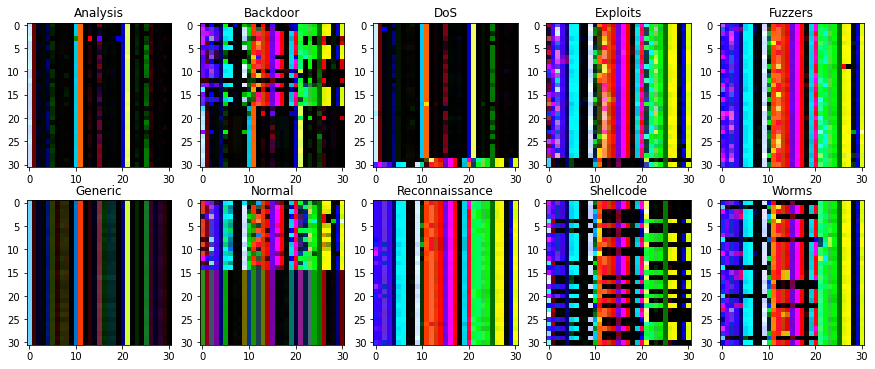

In [40]:
# Read the images for each category, the file name may vary (27.png, 83.png...)
# imgs = [Image.open('./train/{}/93.png'.format(i)) for i in range(len(dfs))]
imgs = list()
titles = list()
Train_Dir='./train/'
for dir in os.listdir(Train_Dir):
    img_files = os.listdir(os.path.join(Train_Dir, dir))
    if len(img_files) != 0: 
        imgs.append(Image.open(os.path.join(Train_Dir, dir, img_files[0])))
        titles.append(dir)
# img1 = Image.open('./train/0/123.png')
# img2 = Image.open('./train/1/123.png')
# img3 = Image.open('./train/2/123.png')
# img4 = Image.open('./train/3/123.png')
# img5 = Image.open('./train/4/123.png')
# img6 = Image.open('./train/0/123.png')
# img7 = Image.open('./train/1/123.png')
# img8 = Image.open('./train/2/123.png')
# img9 = Image.open('./train/3/123.png')
# img10 = Image.open('./train/4/123.png')
# img11 = Image.open('./train/4/123.png')
# titles = df[label_col].value_counts().index.to_list()

plot_row_num = (len(imgs)-1)//5+1
plt.figure(figsize=(15, plot_row_num*3)) 
for i in range(len(imgs)):
    plt.subplot(plot_row_num, 5, i+1)
    plt.imshow(imgs[i])
    plt.title(titles[i])

# plt.subplot(1,5,1)
# plt.imshow(img1)
# plt.title("Normal")
# plt.subplot(1,5,2)
# plt.imshow(img2)
# plt.title("RPM Spoofing")
# plt.subplot(1,5,3)
# plt.imshow(img3)
# plt.title("Gear Spoofing")
# plt.subplot(1,5,4)
# plt.imshow(img4)
# plt.title("DoS Attack")
# plt.subplot(1,5,5)
# plt.imshow(img5)
# plt.title("Fuzzy Attack")

plt.show()  # display it

## Split the training and test set 

In [41]:
# Create folders to store images
Train_Dir='./train/'
Val_Dir='./test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

6984


In [42]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [43]:
# The size of test set
Numbers

1396

In [44]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [45]:
#resize the images 224*224 for better CNN training
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [46]:
DATA_DIR_224='./train_224/'
get_224(folder='./train/',dstdir=DATA_DIR_224)

Finish resizing


In [47]:
DATA_DIR2_224='./test_224/'
get_224(folder='./test/',dstdir=DATA_DIR2_224)

Finish resizing
